<a href="https://colab.research.google.com/github/sr2echa/dirty-moni-detector/blob/main/model_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wreckage011","key":"a54ab5182b2c40fd7a9a36c473a7368b"}'}

In [3]:
!mkdir -p /root/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d vagifa/ethereum-frauddetection-dataset

  0% 0.00/923k [00:00<?, ?B/s]
100% 923k/923k [00:00<00:00, 31.6MB/s]


In [5]:
!mkdir train
!unzip ethereum-frauddetection-dataset.zip -d train

Archive:  ethereum-frauddetection-dataset.zip
  inflating: train/transaction_dataset.csv  


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

pd.set_option('display.max_columns', None)

In [7]:
df=pd.read_csv('/content/train/transaction_dataset.csv')
df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [8]:
df.isna().sum()

Unnamed: 0                                                0
Index                                                     0
Address                                                   0
FLAG                                                      0
Avg min between sent tnx                                  0
Avg min between received tnx                              0
Time Diff between first and last (Mins)                   0
Sent tnx                                                  0
Received Tnx                                              0
Number of Created Contracts                               0
Unique Received From Addresses                            0
Unique Sent To Addresses                                  0
min value received                                        0
max value received                                        0
avg val received                                          0
min val sent                                              0
max val sent                            

0    7662
1    2179
Name: FLAG, dtype: int64


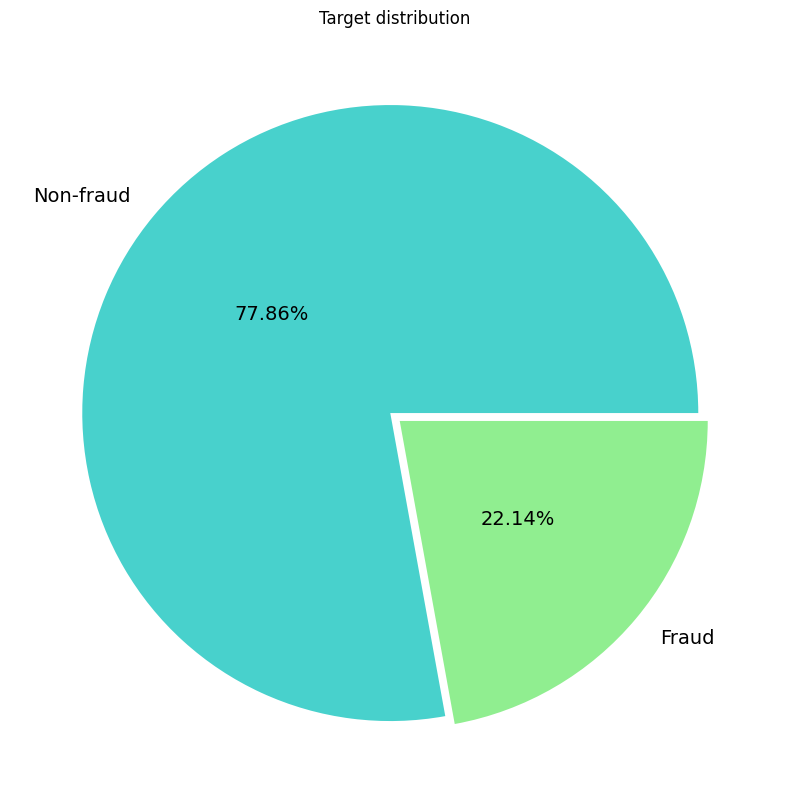

In [9]:
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['mediumturquoise', 'lightgreen']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

<ipython-input-10-9145c739468c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


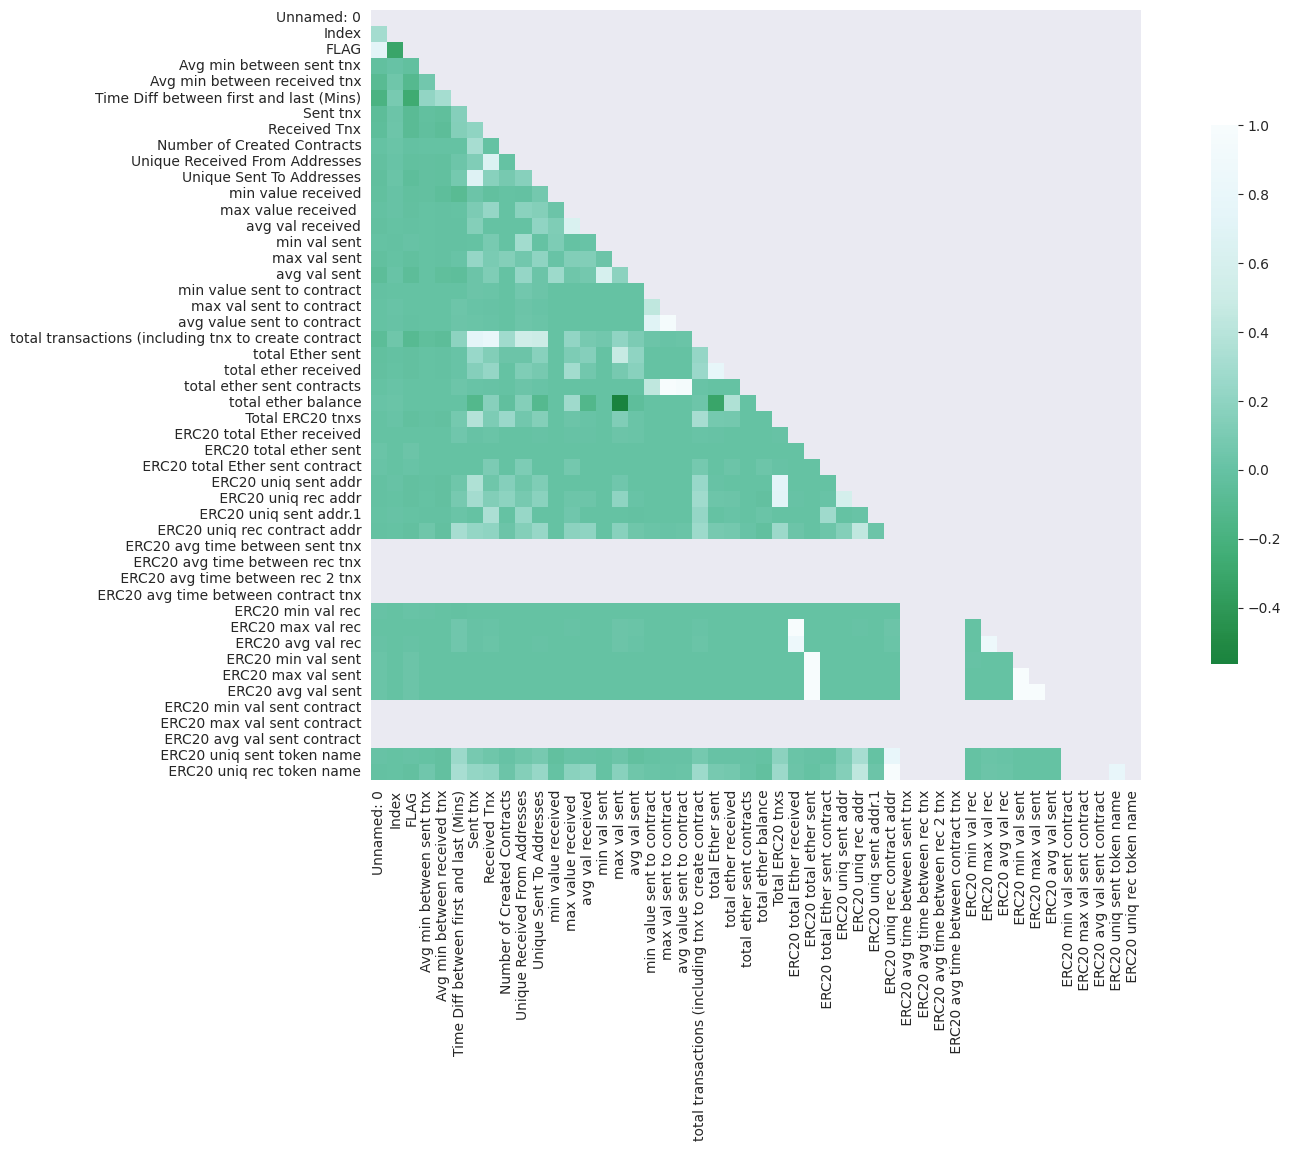

In [ ]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('dark'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='BuGn_r', center=0, square=True,cbar_kws={"shrink": .7})

In [9]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']
print('Categorical columns :',cat_col)
num_col = [col for col in df.columns if df[col].dtype != 'object']
print('Numerical columns :',num_col)

Categorical columns : ['Address', ' ERC20 most sent token type', ' ERC20_most_rec_token_type']
Numerical columns : ['Unnamed: 0', 'Index', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg tim

In [10]:
df.drop(df[cat_col], axis=1, inplace=True)

In [11]:
df.fillna(df.median(), inplace=True)

In [13]:
df.columns

Index(['Unnamed: 0', 'Index', 'FLAG', 'Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time be

In [12]:
col = ['FLAG','Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance',  ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 avg val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent',  ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']

df = df[col]

In [13]:
ex2={
  "FLAG":0,
  "Avg min between received tnx": 586502.2533333333,
  "Avg min between sent tnx": 144512.2026578073,
  "AvgValSent": 0.036209919971877905,
  "AvgValueReceived5Average": 0.05231514198012146,
  "AvgValueSentToContract": 0,
  "ERC20AvgTimeBetweenRec_Tnx": 4423951.333333333,
  "ERC20AvgTimeBetweenSent_Tnx": 1060786.6,
  "ERC20AvgVal_Rec": 6194819.713779431,
  "ERC20AvgVal_Sent": 1286150.8748495427,
  "ERC20MaxVal_Rec": 55000000.0,
  "ERC20MaxVal_Sent": 44550000.0,
  "ERC20MinVal_Rec": 3.245e-15,
  "ERC20MinVal_Sent": 1.5e-10,
  "ERC20TotalEtherSentContract": 45015280.619734,
  "ERC20TotalEther_Received": 55753377.42401488,
  "ERC20TotalEther_Sent": 45015280.619734,
  "ERC20UniqRecContractAddr": 8,
  "ERC20UniqRecTokenName": 8,
  "ERC20UniqRec_Addr": 9,
  "ERC20UniqSentTokenName": 6,
  "ERC20UniqSent_Addr": 28,
  "MaxValSent": 0.66,
  "MaxValueReceived": 0.3880441,
  "MaxValueSentToContract": 0.0,
  "MinValSent": 0.0,
  "MinValueReceived": 0.0,
  "MinValueSentToContract": 0.0,
  "NumberofCreated_Contracts": 0,
  "Received_tnx": 75,
  "Sent_tnx": 301,
  "Time Diff between first and_last (Mins)": 733696.0166666667,
  "TotalEtherBalance": -6.9755502630261415,
  "TotalEtherReceived": 3.923635648509109,
  "TotalEtherSent": 10.89918591153525,
  "TotalEtherSent_Contracts": 0.0,
  "TotalTransactions": 375,
  "UniqueReceivedFrom_Addresses": 21,
  "UniqueSentTo_Addresses20": 99
}

ex1={
  "FLAG":1,
  "Avg min between received tnx": 0,
  "Avg min between sent tnx": 1551.5625,
  "AvgValSent": 185.43750000000003,
  "AvgValueReceived5Average": 2967.0000000000005,
  "AvgValueSentToContract": 0,
  "ERC20AvgTimeBetweenRec_Tnx": 14193276.0,
  "ERC20AvgTimeBetweenSent_Tnx": 0,
  "ERC20AvgVal_Rec": 7.005e-13,
  "ERC20AvgVal_Sent": 0,
  "ERC20MaxVal_Rec": 1.4e-12,
  "ERC20MaxVal_Sent": 0.0,
  "ERC20MinVal_Rec": 1e-15,
  "ERC20MinVal_Sent": 0.0,
  "ERC20TotalEtherSentContract": 0.0,
  "ERC20TotalEther_Received": 1.401e-12,
  "ERC20TotalEther_Sent": 0.0,
  "ERC20UniqRecContractAddr": 2,
  "ERC20UniqRecTokenName": 2,
  "ERC20UniqRec_Addr": 2,
  "ERC20UniqSentTokenName": 0,
  "ERC20UniqSent_Addr": 0,
  "MaxValSent": 1467.0,
  "MaxValueReceived": 2967.0,
  "MaxValueSentToContract": 0.0,
  "MinValSent": 100.0,
  "MinValueReceived": 2967.0,
  "MinValueSentToContract": 0.0,
  "NumberofCreated_Contracts": 0,
  "Received_tnx": 1,
  "Sent_tnx": 16,
  "Time Diff between first and_last (Mins)": 1161.3166666666666,
  "TotalEtherBalance": 0.0,
  "TotalEtherReceived": 2967.0,
  "TotalEtherSent": 2967.0,
  "TotalEtherSent_Contracts": 0.0,
  "TotalTransactions": 17,
  "UniqueReceivedFrom_Addresses": 1,
  "UniqueSentTo_Addresses20": 2
}

old_keys = [
    'FLAG', 'Avg min between received tnx', 'Avg min between sent tnx', 'AvgValSent',
    'AvgValueReceived5Average', 'AvgValueSentToContract', 'ERC20AvgTimeBetweenRec_Tnx',
    'ERC20AvgTimeBetweenSent_Tnx', 'ERC20AvgVal_Rec', 'ERC20AvgVal_Sent', 'ERC20MaxVal_Rec',
    'ERC20MaxVal_Sent', 'ERC20MinVal_Rec', 'ERC20MinVal_Sent', 'ERC20TotalEtherSentContract',
    'ERC20TotalEther_Received', 'ERC20TotalEther_Sent', 'ERC20UniqRecContractAddr',
    'ERC20UniqRecTokenName', 'ERC20UniqRec_Addr', 'ERC20UniqSentTokenName', 'ERC20UniqSent_Addr',
    'MaxValSent', 'MaxValueReceived', 'MaxValueSentToContract', 'MinValSent',
    'MinValueReceived', 'MinValueSentToContract', 'NumberofCreated_Contracts', 'Received_tnx',
    'Sent_tnx', 'Time Diff between first and_last (Mins)', 'TotalEtherBalance', 'TotalEtherReceived',
    'TotalEtherSent', 'TotalEtherSent_Contracts', 'TotalTransactions', 'UniqueReceivedFrom_Addresses',
    'UniqueSentTo_Addresses20'
]

new_col = [
    'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)',
    'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses',
    'min value received', 'max value received', 'avg val received', 'min val sent', 'max val sent',
    'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract',
    'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received',
    'total ether sent contracts', 'total ether balance', ' ERC20 total Ether received',
    ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq rec addr',
    ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx',
    ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 avg val rec', ' ERC20 min val sent', ' ERC20 max val sent',
    ' ERC20 avg val sent', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract',' ERC20 uniq sent addr'
]

# Assume the `ex2` dictionary is defined somewhere above with correct 'FLAG' key-value assignment

# Create a mapping dictionary using a dictionary comprehension
key_mapping = {old_key: new_col[i] for i, old_key in enumerate(old_keys)}

# Map the old dictionary to a new one with the new keys
new_ex2 = {key_mapping.get(k, k): v for k, v in ex2.items()}
new_ex1 = {key_mapping.get(k, k): v for k, v in ex1.items()}
# Assuming `df` is a pandas DataFrame that already exists
df = df.append(new_ex2, ignore_index=True)
df = df.append(new_ex1, ignore_index=True)

<ipython-input-13-0928f422da23>:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_ex2, ignore_index=True)
<ipython-input-13-0928f422da23>:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_ex1, ignore_index=True)


In [18]:
df.shape

(9843, 40)

In [15]:
df.drop("max value received",axis=1,inplace=True)

In [19]:
X = df.drop('FLAG', axis=1)
y = df['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
model = Sequential([
    Dense(39, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
222/222 [==============================] - 2s 4ms/step - loss: 0.4194 - accuracy: 0.8151 - val_loss: 0.2503 - val_accuracy: 0.9124
Epoch 2/50
222/222 [==============================] - 1s 3ms/step - loss: 0.2270 - accuracy: 0.9214 - val_loss: 0.1576 - val_accuracy: 0.9315
Epoch 3/50
222/222 [==============================] - 1s 6ms/step - loss: 0.1847 - accuracy: 0.9287 - val_loss: 0.1278 - val_accuracy: 0.9454
Epoch 4/50
222/222 [==============================] - 1s 5ms/step - loss: 0.1673 - accuracy: 0.9393 - val_loss: 0.1300 - val_accuracy: 0.9429
Epoch 5/50
222/222 [==============================] - 2s 7ms/step - loss: 0.1681 - accuracy: 0.9431 - val_loss: 0.1302 - val_accuracy: 0.9594
Epoch 6/50
222/222 [==============================] - 1s 6ms/step - loss: 0.2229 - accuracy: 0.9235 - val_loss: 0.1209 - val_accuracy: 0.9607
Epoch 7/50
222/222 [==============================] - 1s 5ms/step - loss: 0.1642 - accuracy: 0.9459 - val_loss: 0.0993 - val_accuracy: 0.9670
Epoch 

In [23]:
predictions=model.predict(X_test_scaled)

binary_predictions = (predictions > 0.5).astype(int)

# Flatten the array to match the shape of y_test
binary_predictions = binary_predictions.flatten()

# Calculate accuracy and precision
test_accuracy = accuracy_score(y_test, binary_predictions)
test_precision = precision_score(y_test, binary_predictions)

# Print the scores
print(f'Accuracy on test set: {test_accuracy:.4f}')
print(f'Precision on test set: {test_precision:.4f}')

62/62 [==============================] - 0s 2ms/step
Accuracy on test set: 0.9558
Precision on test set: 0.8731


In [25]:
model.save("DMD.h5")

In [26]:
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler
from joblib import load

# Step 1: Make the HTTP GET request to retrieve the JSON data
response = requests.get('https://dirtyapi.replit.app/api/0xfd7fd7c934dff1c2c6278acb043ad75a4262cd92')
response1 = requests.get('https://dirtyapi.replit.app/api/0xCA67615bb9a9Cc093E13deE3dE1CA55B55AB3586')
# Step 2: Convert the JSON response to a Python dictionary
dtf1 = response.json()
dtf2 = response1.json()
# Step 3: Delete the specified keys from the dictionary
del dtf1["ERC20MostSentTokenType"]
del dtf1["ERC20MostRecTokenType"]
del dtf2["ERC20MostSentTokenType"]
del dtf2["ERC20MostRecTokenType"]

# Convert the remaining dictionary to a pandas DataFrame
df1 = pd.DataFrame([dtf1])  # Wrapping dtf in a list to make sure it's treated as a single row
df2 = pd.DataFrame([dtf2])
# If you need to drop the 'Address' column as well, assuming it's there
if 'Address' in df1.columns:
    df1.drop(['Address'], axis=1, inplace=True)
if 'Address' in df2.columns:
    df2.drop(['Address'], axis=1, inplace=True)



In [27]:
# Step 4: Scale the features using StandardScaler if your model requires scaled input

from keras.models import load_model
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df1)
df_scaled_one = scaler.fit_transform(df2)
# At this point, `df_scaled` is a 2D numpy array and ready to be passed to your model.
# Assuming your model is loaded as `loaded_model`

loaded_model=load_model(r'/content/DMD.h5')
predictions1 = loaded_model.predict(df_scaled)
predictions2 = loaded_model.predict(df_scaled_one)
# Step 5: Print the predictions
print(predictions1)
print(predictions2)

1/1 [==============================] - 0s 32ms/step
[[3.8410806e-05]]
[[3.8410806e-05]]
